In [1]:
import os
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd

from icecream import ic, colorize as ic_colorize, argumentToString

sns.set_theme(rc={"legend.facecolor": "w"})
mpl.rcParams["pdf.fonttype"] = 42

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# Register a function to summarize numpy array
@argumentToString.register
def argumentToString_ndarray(obj: np.ndarray):
  return (
    f"ndarray, shape={obj.shape}, dtype={obj.dtype}, "
    f"min={obj.min()}, max={obj.max()}"
  )


ic.configureOutput(prefix="⚡ ")
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

np.set_printoptions(threshold=5, precision=2, edgeitems=2, linewidth=200, suppress=True)

%load_ext autoreload
%autoreload 2

In [2]:
from admice.dataload import session_from_mouse_from_matfile, load_mice_from_mat 

In [113]:
data_root = os.path.expanduser("~/data/tedho_ad_mice/")

def jdr(fname:str) -> str:
  return os.path.join(data_root, fname)

sess_ctrl = load_mice_from_mat(jdr("workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"), "controlmice", "control")
sess_young = load_mice_from_mat(jdr("workspace_28-Jun-2024_young3xtg_mice_2p_data_for_dan.v7.mat"), "young3xtgmice", "young_3xtg")
sess_old = load_mice_from_mat(jdr("workspace_28-Jun-2024_old3xtg_mice_2p_data_for_dan.v7.mat"), "old3xtgmice", "old_3xtg")

bad_mouse_ids = [16, 22, 52]

# filter out 3 bad mice Ted mentioned in Slack
# sess_young = [mouse for mouse in sess_young if mouse.mouse_id not in [16, 22]]
# sess_old = [mouse for mouse in sess_old if mouse.mouse_id not in [52]]
# ic([mouse.mouse_id for mouse in sess_ctrl]);
# ic([mouse.mouse_id for mouse in sess_young]);
# ic([mouse.mouse_id for mouse in sess_old]);

### Try filtering sliding


In [4]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

In [5]:
filt_strat = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23,
  window_buffer_pre = 4, 
  reduce_mode_pre = "mean",
  window_width_post= 3,
  window_buffer_post = 0, 
  reduce_mode_post = "max" 
)

In [6]:
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 45)

### debugging


In [22]:
filt_strat_short = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23,
  window_buffer_pre = 2, 
  reduce_mode_pre = "max",
  window_width_post= 13,
  window_buffer_post = 2, 
  reduce_mode_post = "max" 
)
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 45)

In [10]:
from admice.eventlda_sliding import filter_sliding, pipeline_lda_sliding

sess = sess_old[0]
res = pipeline_lda_sliding(sess, sess.puff_ind, filt_strat_short, samp_strat, seed=1)

2024-08-02 15:45:14,026	INFO worker.py:1788 -- Started a local Ray instance.


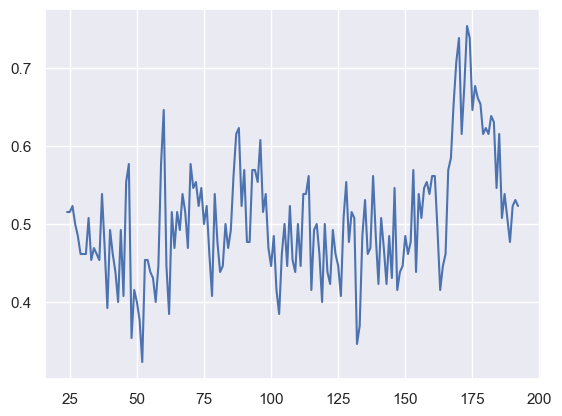

In [11]:
plt.plot(res)

In [19]:
from numba import njit 
import random

def pick_pos_neg_data_sliding(
  filt_nrt: np.ndarray,
  event_ind: int,
  filt_strat: FilteringStrategy,
  seed: int = 42,
  valid_neg_mask_tt: np.ndarray | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
  """
  Extracts positive and negative datapoints for each trial, at each positive time

  Args:
      filt_nrt (np.ndarray): filtered input data
      event_ind (int): used to exclude negative timepoints after event
      exclude_window_width (int): averaging window width used for filtering
      seed (int, optional): random seed. Defaults to 42.
      valid_neg_mask_tt (pass back in to save time)

  Returns:
      pos_data_nrt, neg_data_nrt, valid_neg_mask_tt
  """

  if valid_neg_mask_tt is None:
    window_width_pre = filt_strat.window_width_pre
    window_buffer_pre = filt_strat.window_buffer_pre

    # pick random pre-tone, non-overlapping indices for each trial for neg timepoint
    N, R, T = filt_nrt.shape

    # valid mask is T(as pos_ind) x T(as eligible) mask of eligible timepoints for each trial for the neg sample

    # disallow idx where the filtered data is missing
    valid_neg_mask_tt = np.zeros((T, T), dtype=np.int32)
    valid_neg_mask_tt[...] = np.logical_not(np.isnan(filt_nrt[0, 0]))

    # disallow idx which overlap with the positive sample (first index)'s averaging window
    exclude_window_width = window_width_pre + window_buffer_pre
    for t in range(T):
      valid_neg_mask_tt[t, t : min(t + exclude_window_width, T)] = False

    # disallow idx after the tone
    valid_neg_mask_tt[:, event_ind:] = False

  pos_data = filt_nrt

  @njit
  def choose_neg_data(filt_nrt: np.ndarray, seed:int):
    # sample the negative timepoint in each trial, for each pos_ind timepoint
    random.seed(seed)
    _, R, T = filt_nrt.shape
    neg_data = np.zeros_like(filt_nrt)
    for t in range(T):
      valid_indices = np.where(valid_neg_mask_tt[t, :])[0]
      for r in range(R):
        which_ind = random.randrange(len(valid_indices))
        neg_time_idx = valid_indices[which_ind]
        neg_data[:, r, t] = filt_nrt[:, r, neg_time_idx]

    return neg_data

  return pos_data, choose_neg_data(filt_nrt, seed), valid_neg_mask_tt

filt_nrt = filter_sliding(sess.data_nrt, filt_strat_short)
pos_nrt, neg_nrt, valid_neg_mask_tt = pick_pos_neg_data_sliding(filt_nrt, sess.puff_ind, filt_strat_short, seed=1)

In [21]:
pick_pos_neg_data_sliding(filt_nrt, sess.tone_ind, filt_strat_short, seed=1, 
  valid_neg_mask_tt=valid_neg_mask_tt);

(array([[[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        ...,
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]]]),
 array([[[-1.6 ,  0.06, ..., -0.93,  0.23],
         [ 0.  , -0.2 , ..., -0.74,  0.24],
         ...,
         [-1.44, -0.14, ..., -1.  , -0.63],
         [ 0.44, -0.52, ...,  0.92, -0.87]],
 
        [[-0.97,  0.05, ..., -0.2 ,  0.04],
         [ 0.33, -0.75, ..., -1.18, -0.7 ],
         ...,
         [ 1.27, -0.91, ..., -0.34, -1.14],
  

In [1]:
pos_nrt

NameError: name 'pos_nrt' is not defined

In [23]:
from admice.eventlda_sliding import lda_sliding_parallel_samples 
res = lda_sliding_parallel_samples(
  sess,
  sess.tone_ind,
  filt_strat,
  samp_strat,
  n_samples = 10,
  n_batches = 8,
)

### running


In [50]:
filt_strat = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23,
  window_buffer_pre = 4, 
  reduce_mode_pre = "mean",
  window_width_post= 3,
  window_buffer_post = 0, 
  reduce_mode_post = "max" 
)

samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

In [64]:
from admice.eventlda_sliding import multimouse_pipeline_lda_sliding

n_samples = 1000
time_range_rel_tone = [-31, 62]

res_ctrl_tone = multimouse_pipeline_lda_sliding(
  sess_ctrl,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

res_young_tone = multimouse_pipeline_lda_sliding(
  sess_young,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

res_old_tone = multimouse_pipeline_lda_sliding(
  sess_old,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

(pid=92510) control 0 / 7: id 27 0:   0%|          | 0/651000 [00:00<?, ?it/s]

(pid=72394)  0:   0%|          | 0/651000 [00:00<?, ?it/s]

(pid=48656) old_3xtg 0 / 6: id 28 0:   0%|          | 0/558000 [00:00<?, ?it/s]

In [69]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
if not os.path.exists(analysis_root):
  os.mkdir(analysis_root)

with open(os.path.join(analysis_root, 'lda_sliding_samples.pkl'), 'wb') as file:
  pickle.dump({'ctrl': res_ctrl_tone, 'young': res_young_tone, 'old': res_old_tone}, file)

In [71]:
# reload from disk
with open(os.path.join(analysis_root, 'lda_sliding_samples.pkl'), 'rb') as file:
  ld = pickle.load(file)

⚡ ld: {'ctrl': EventLDAResultsSliding(group='control',
                                      mouse_ids=[27, 15, 17, 25, 33, 34, 35],
                                      align_inds=[148, 147, 149, 147, 148, 148, 148],
                                      accuracy_s_ct=[array([[nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan],
             ...,
             [nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan]]),
                                                     array([[nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan],
             ...,
             [nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan]]),
                                                     array([[nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan],
             ...,
             [nan, nan, ..., nan, nan],
             [nan, nan, ..., nan, nan]]),
                                                     array([[nan, nan, ..., nan, nan],
             

{'ctrl': EventLDAResultsSliding(group='control', mouse_ids=[27, 15, 17, 25, 33, 34, 35], align_inds=[148, 147, 149, 147, 148, 148, 148], accuracy_s_ct=[array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]), array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]), array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]), array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]), array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]), array([[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        .

Text(0, 0.5, 'accuracy')

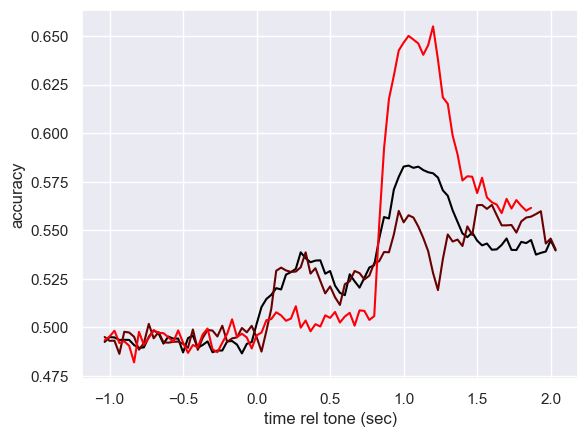

In [65]:
# quick plot of accuracy vs. time
c_ctrl = '#000000'
c_young= '#680200'
c_old = '#FB0007'

ctrl_sct, tvec, tone_ind = res_ctrl_tone.get_aligned_accuracy()
plt.plot(tvec, np.mean(ctrl_sct, axis=(0,1)), color=c_ctrl)

young_sct, tvec, tone_ind = res_young_tone.get_aligned_accuracy()
plt.plot(tvec, np.mean(young_sct, axis=(0,1)), color=c_young)

old_sct, tvec, tone_ind = res_old_tone.get_aligned_accuracy()
plt.plot(tvec, np.mean(old_sct, axis=(0,1)), color=c_old)

plt.xlabel("time rel tone (sec)")
plt.ylabel("accuracy")
# plt.xlim([-2, 1])

In [81]:
# now generate mouse averages and combined data frame
res_ctrl_cavg = res_ctrl_tone.averaged_over_samples()
res_young_cavg = res_young_tone.averaged_over_samples()
res_old_cavg = res_old_tone.averaged_over_samples()

df_ctrl = res_ctrl_cavg.to_df()
df_young = res_young_cavg.to_df()
df_old = res_old_cavg.to_df()
df_all = pd.concat([df_ctrl, df_young, df_old], ignore_index=True)
df_all["error"] = 1. - df_all["accuracy"]

In [95]:
# compute median puff time
puff_rel_tone_time = np.median([(mouse.puff_ind - mouse.tone_ind - 1) / mouse.fps for mouse in (sess_ctrl + sess_young + sess_old)])

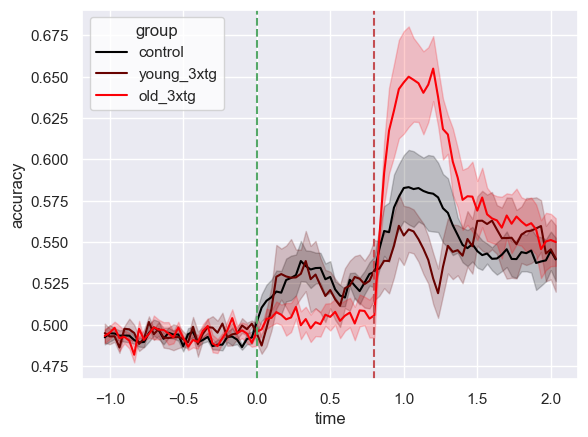

In [105]:
palette = {'control': c_ctrl, 'young_3xtg': c_young, 'old_3xtg': c_old}
sns.lineplot(data=df_all, x="time", y="accuracy", hue="group", palette=palette, errorbar='se')
plt.axvline(0, linestyle='--', color='g')
plt.axvline(puff_rel_tone_time, linestyle='--', color='r')

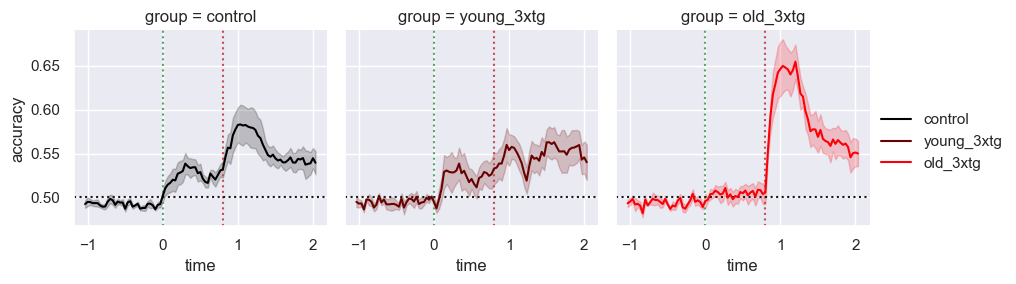

In [106]:
palette = {'control': c_ctrl, 'young_3xtg': c_young, 'old_3xtg': c_old}

# Create the FacetGrid
g = sns.FacetGrid(df_all, col="group", col_wrap=3, sharey=True)

# Apply the vertical lines to each subplot
def add_axlines(*args, **kwargs):
    plt.axvline(0, linestyle='dotted', color='g')
    plt.axvline(puff_rel_tone_time, linestyle='dotted', color='r')
    plt.axhline(0.5, linestyle='dotted', color='k')

g.map(add_axlines)

# Map the sns.lineplot function to each subplot
g.map_dataframe(sns.lineplot, x="time", y="accuracy", errorbar='se', hue="group", palette=palette)


# Adjust the layout
g.add_legend()
plt.show()

In [120]:
# filter ids
df_good = df_all[~df_all['mouse_id'].isin(bad_mouse_ids)]

with np.printoptions(threshold=np.inf):
  print(np.unique(df_all['mouse_id']))
  print(np.unique(df_good['mouse_id']))


[15 16 17 18 19 20 22 23 24 25 27 28 29 30 31 32 33 34 35 52]
[15 17 18 19 20 23 24 25 27 28 29 30 31 32 33 34 35]


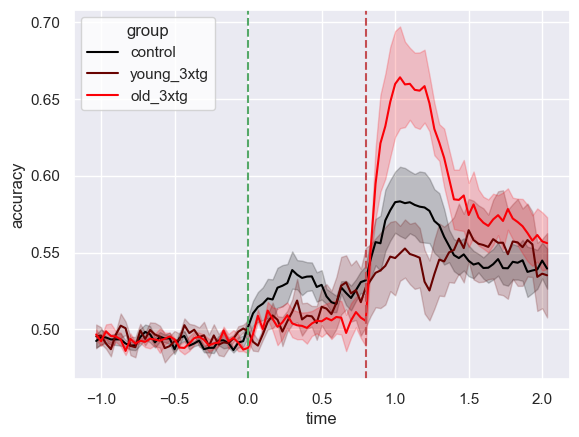

In [121]:
palette = {'control': c_ctrl, 'young_3xtg': c_young, 'old_3xtg': c_old}
sns.lineplot(data=df_good, x="time", y="accuracy", hue="group", palette=palette, errorbar='se')
plt.axvline(0, linestyle='--', color='g')
plt.axvline(puff_rel_tone_time, linestyle='--', color='r')

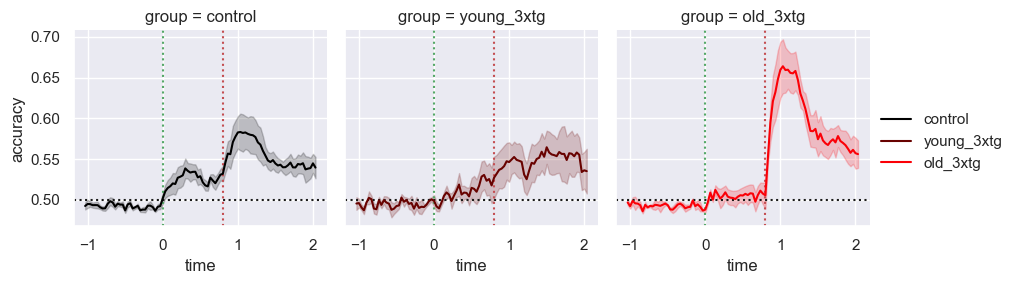

In [122]:
palette = {'control': c_ctrl, 'young_3xtg': c_young, 'old_3xtg': c_old}

# Create the FacetGrid
g = sns.FacetGrid(df_good, col="group", col_wrap=3, sharey=True)

# Apply the vertical lines to each subplot
def add_axlines(*args, **kwargs):
    plt.axvline(0, linestyle='dotted', color='g')
    plt.axvline(puff_rel_tone_time, linestyle='dotted', color='r')
    plt.axhline(0.5, linestyle='dotted', color='k')

g.map(add_axlines)

# Map the sns.lineplot function to each subplot
g.map_dataframe(sns.lineplot, x="time", y="accuracy", errorbar='se', hue="group", palette=palette)


# Adjust the layout
g.add_legend()
plt.show()

In [10]:
# puff_inds = [sess.puff_ind for sess in sess_ctrl]
# res_ctrl_pp = res_ctrl.invalidated_before_event_inds(puff_inds)

# puff_inds = [sess.puff_ind for sess in sess_young]
# res_young_pp = res_young.invalidated_before_event_inds(puff_inds)

# puff_inds = [sess.puff_ind for sess in sess_old]
# res_old_pp = res_old.invalidated_before_event_inds(puff_inds)